## Daniel Alonso, UID: 100444499

<img src='./images/1.png'>

<img src='./images/2.png'>

## Problem 1-a

Let $i$ be the source of a movement and $j$ be the destination

Let $x$ be movements from one node to another, where $x_{i,j}$ represents the movement from node $i$ to node $j$

Integer optimization formulation:

minimize $44x_{1,2} + 18x_{1,3} + 85x_{1,4} + 17x_{2,5} + 13x_{2,6} + 55x_{3,5} + 53x_{3,6} + 7x_{3,7} + 26x_{4,6} + 66x_{4,7} + 6x_{5,8} + 7x_{5,9} + 26x_{6,8} + 66x_{6,9} + 26x_{6,10} + 6x_{7,9} + 60x_{7,10} + 58x_{8,11} + 70x_{9,11} + 27x_{10,11}$

subject to:

$x_{1,2} + x_{1,3} + x_{1,4} = 1$

$x_{1,2} - x_{2,5} - x_{2,6} = 0 $

$x_{1,3} - x_{3,5} - x_{3,6} - x_{3,7} = 0$

$x_{1,4} - x_{4,6} - x_{4,7} = 0$

$x_{2,5} + x_{3,5} - x_{5,8} - x_{5,9} = 0$

$x_{2,6} + x_{3,6} + x_{4,6} - x_{6,8} - x_{6,9} - x_{6,10} = 0$

$x_{3,7} + x_{4,7} - x_{7,9} - x_{7,10} = 0$

$x_{5,8} + x_{6,8} - x_{8,11} = 0$

$x_{5,9} + x_{6,9} + x_{7,9} - x_{9,11} = 0$

$x_{6,10} + x_{7,10} - x_{10,11} = 0$

$- x_{8,11} - x_{9,11} - x_{10,11} = -1$

The integer optimization formulation (in my opinion) is more appropriate. It not only will provide the optimal integer solution but it also describes the problem better and more accurately.

Using ordinary linear optimization forces us to estimate values and would make the process more convoluted even though the integer optimization problem could, perhaps be more computationally challenging depending on the size of the graph. 

## Problem 1-b

In [160]:
# Gurobi-python implementation
from gurobipy import *
import pandas as pd
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [161]:
nodes, supply = multidict({
         1: 1,
         2: 0,
         3: 0,
         4: 0,
         5: 0,
         6: 0,
         7: 0,
         8: 0,
         9: 0,
         10: 0,
         11: -1})
 
arcs, distance = multidict({
    (1, 2): 44,
    (1, 3): 18,
    (1, 4): 85,
    (2, 5): 17,
    (2, 6): 13,
    (3, 5): 55,
    (3, 6): 53,
    (3, 7): 7,
    (4, 6): 26,
    (4, 7): 66,
    (5, 8): 6,
    (5, 9): 7,
    (6, 8): 26,
    (6, 9): 66,
    (6, 10): 26,
    (7, 9): 6,
    (7, 10): 60,
    (8, 11): 58,
    (9, 11): 70,
    (10, 11): 27})

num_nodes = 11

# Optimization model
m = Model('shortest_path')
x = m.addVars(arcs, obj=distance, name="dist")
m.addConstrs((x.sum(i, '*') - x.sum('*', i) == supply[i] for i in nodes), "supply")
m.ModelSense = GRB.MINIMIZE
m.optimize()


Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (linux64)
Optimize a model with 11 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xd11ad6da
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6 rows and 6 columns
Presolve time: 0.00s
Presolved: 5 rows, 14 columns, 28 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5000000e+01   2.000000e+00   0.000000e+00      0s
       2    1.0100000e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds
Optimal objective  1.010000000e+02


In [162]:
# Printing solution
# Variable information including sensitivity information
varnames = [f"x[{tuple(x)}]" for x in tuple(arcs)]
for var, v in zip(varnames,m.getVars()):
    print(f"{var} = {v.X}")

x[(1, 2)] = 0.0
x[(1, 3)] = 1.0
x[(1, 4)] = 0.0
x[(2, 5)] = 0.0
x[(2, 6)] = 0.0
x[(3, 5)] = 0.0
x[(3, 6)] = 0.0
x[(3, 7)] = 1.0
x[(4, 6)] = 0.0
x[(4, 7)] = 0.0
x[(5, 8)] = 0.0
x[(5, 9)] = 0.0
x[(6, 8)] = 0.0
x[(6, 9)] = 0.0
x[(6, 10)] = 0.0
x[(7, 9)] = 1.0
x[(7, 10)] = 0.0
x[(8, 11)] = 0.0
x[(9, 11)] = 1.0
x[(10, 11)] = 0.0


We can clearly see the shortest route from node 1 to node 11 is the following:

$x_{1,3} \rightarrow x_{3,7} \rightarrow x_{7,9} \rightarrow x_{9,11}$

<img src='./images/path.png'>

## Problem 1-c

In [163]:
# Optimal shadow prices
for n,c in enumerate(m.getConstrs()):
    print(f"{c.ConstrName} : shadow price = {int(c.Pi)}")

supply[1] : shadow price = 48
supply[2] : shadow price = 4
supply[3] : shadow price = 30
supply[4] : shadow price = -37
supply[5] : shadow price = 0
supply[6] : shadow price = 0
supply[7] : shadow price = 23
supply[8] : shadow price = 5
supply[9] : shadow price = 17
supply[10] : shadow price = -26
supply[11] : shadow price = -53


In [164]:
# Printing solution
# Variable information including sensitivity information
varnames = [f"x[{tuple(x)}]" for x in tuple(arcs)]
for var, v in zip(varnames,m.getVars()):
    print(f"{var} = {int(v.X)}, reduced cost = {abs(int(v.RC)):.2f}")

x[(1, 2)] = 0, reduced cost = 0.00
x[(1, 3)] = 1, reduced cost = 0.00
x[(1, 4)] = 0, reduced cost = 0.00
x[(2, 5)] = 0, reduced cost = 13.00
x[(2, 6)] = 0, reduced cost = 9.00
x[(3, 5)] = 0, reduced cost = 25.00
x[(3, 6)] = 0, reduced cost = 23.00
x[(3, 7)] = 1, reduced cost = 0.00
x[(4, 6)] = 0, reduced cost = 63.00
x[(4, 7)] = 0, reduced cost = 126.00
x[(5, 8)] = 0, reduced cost = 11.00
x[(5, 9)] = 0, reduced cost = 24.00
x[(6, 8)] = 0, reduced cost = 31.00
x[(6, 9)] = 0, reduced cost = 83.00
x[(6, 10)] = 0, reduced cost = 0.00
x[(7, 9)] = 1, reduced cost = 0.00
x[(7, 10)] = 0, reduced cost = 11.00
x[(8, 11)] = 0, reduced cost = 0.00
x[(9, 11)] = 1, reduced cost = 0.00
x[(10, 11)] = 0, reduced cost = 0.00


While very interesting, there might not be a ton to do with the shadow prices or reduced costs as they might impose changes on a seemingly impossible to change graph. Assuming, obviously, that stuff we move always comes from node 1, then in order to effectively use the information we get from the shadow prices or reduced costs we would have to modify the graph to see how the route between node 1 and node 11 changes.

Distances between locations rarely ever change, therefore the information isn't particularly practical.

We could maybe impose a different scenario where our starting node is different to node 1 and we could, perhaps, obtain a different path.

Maybe we can experiment a little bit with the reduced costs:

In [165]:
# constructing a loop to modify the distances in an unrealistic manner to see how routes would change using our reduced costs
sols = {k:{s:0 for s in tuple(arcs)} for k in tuple(arcs)}
orig_distance = distance.copy()
for d, red_cost in zip(distance,[v.RC for v in m.getVars()]):
    distance = orig_distance.copy()
    if red_cost < distance[d]:
        distance[d] -= red_cost

        # Optimization model
        m = Model('shortest_path')
        x = m.addVars(arcs, obj=distance, name="dist")
        m.addConstrs((x.sum(i, '*') - x.sum('*', i) == supply[i] for i in nodes), "supply")
        m.ModelSense = GRB.MINIMIZE
        m.optimize()

        varnames = [x for x in tuple(arcs)]
        for var, v in zip(varnames,m.getVars()):
            sols[d][var] = v.X

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (linux64)
Optimize a model with 11 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xd11ad6da
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6 rows and 6 columns
Presolve time: 0.00s
Presolved: 5 rows, 14 columns, 28 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5000000e+01   2.000000e+00   0.000000e+00      0s
       2    1.0100000e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds
Optimal objective  1.010000000e+02
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (linux64)
Optimize a model with 11 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xd11ad6da
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6 

<AxesSubplot:>

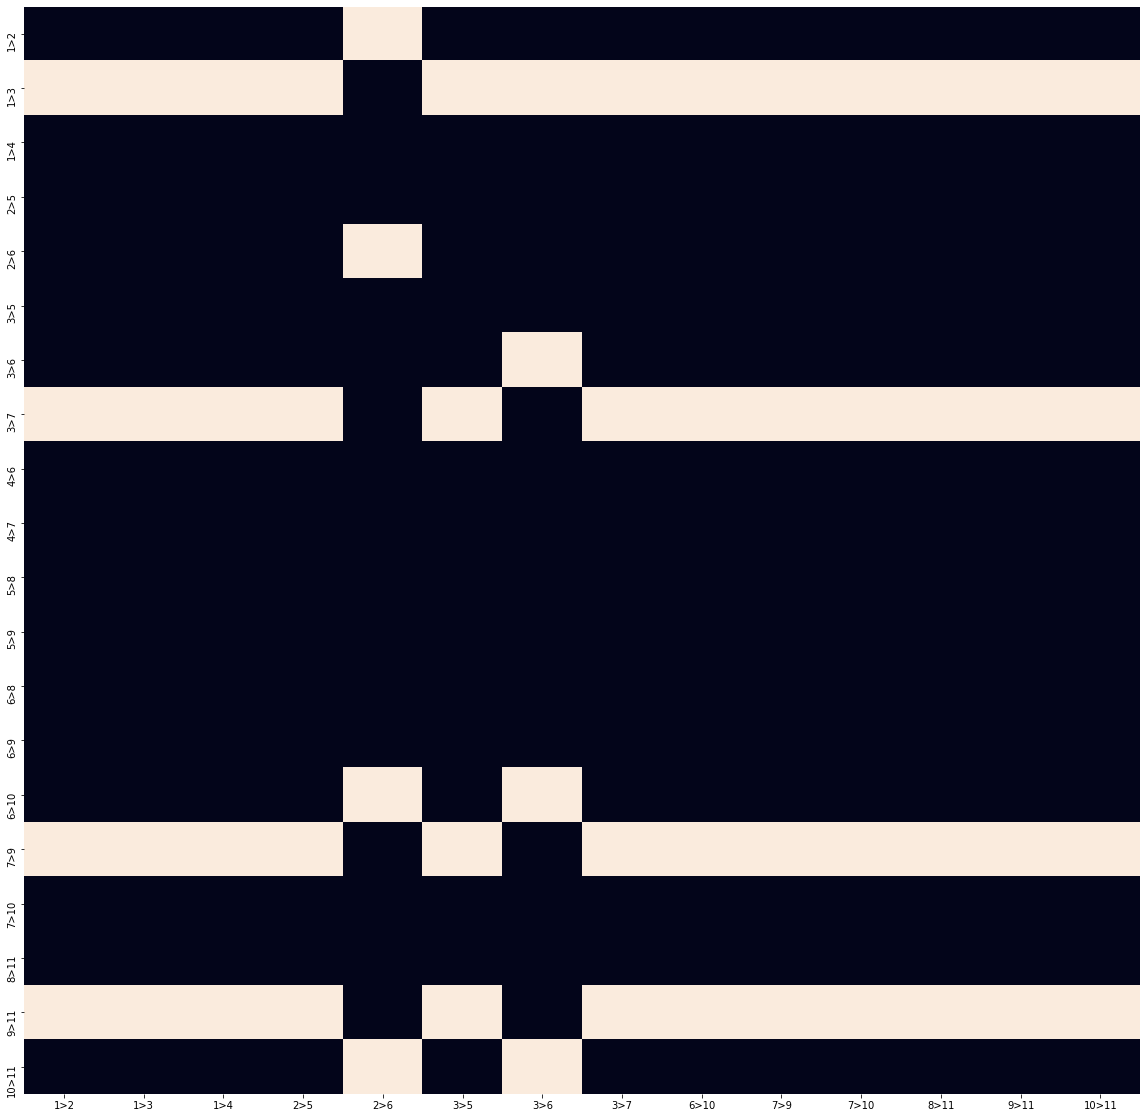

In [166]:
# route changes after applying reduced costs that don't make distances negative (as that's not possible)
sols2 = {}
remove = []
for key in sols.keys():
    sols2[f"{key[0]}>{key[1]}"] = {}
for key in sols.keys():
    for key2,val in sols[key].items():
        sols2[f"{key[0]}>{key[1]}"][f"{key2[0]}>{key2[1]}"] = val
    if pd.DataFrame(sols2)[f"{key[0]}>{key[1]}"].sum() == 0:
        remove.append(f"{key[0]}>{key[1]}")
df = pd.DataFrame(sols2)
df = df[[x for x in df.columns if x not in remove]]

fig = plt.figure(figsize=(20,20))
sns.heatmap(df, cbar=False)

We clearly see, after applying each reduced cost individually that the reduced costs that seem to affect the route are uniquely the reduced cost applied to $x_{2,6}$ and the reduced cost applied to $x_{3,6}$.

Of course, different combinations of reduced costs would change the path in different ways, however, we can see that by themselves, these would be the changes to the paths

Our heatmap shows in BLACK the nodes that would NOT be taken. while the nodes in white would be taken.

our shortest path after applying the reduced cost for $x_{2,6}$ would be (basically reducing the distance between node 2 and node 6):

$x_{1,2} \rightarrow x_{2,6} \rightarrow x_{6,10} \rightarrow x_{10,11}$

our shortest path after applying the reduced cost for $x_{3,6}$ would be (basically reducing the distance between node 2 and node 6):

$x_{1,3} \rightarrow x_{3,6} \rightarrow x_{6,10} \rightarrow x_{10,11}$

Which are, admittedly, similar paths.


<img src='./images/3.png'>

## Problem 2-a

$x_{1}, x_{2}, x_{3}, x_{4} \in \mathbb{N}$

$y_{1}, y_{2}, y_{3}, y_{4} \in \{0, 1\}$

maximize $49x_{1} - 993y_{1} + 54x_{2} - 715y_{2} + 47x_{3} - 834y_{3} + 51x_{4} - 940y_{4}$

subject to:

$x_{1} \leq 2500 y_{1}$, $x_{2} \leq 2500 y_{2}$, $x_{3} \leq 2500 y_{3}$, $x_{4} \leq 2500 y_{4}$

$3x_{1} + 3x_{2} + 5x_{3} + 6x_{4} \leq 598$

$6x_{1} + 3x_{2} + 4x_{3} + 3x_{4} \leq 287$

$6x_{1} + 6x_{2} + 2x_{3} + 7x_{4} \leq 392$











## Problem 2-b

<img src='./images/4.png'>

## Problem 3-a

In [167]:
# objects
n = 24 

# define k
def k(v):
    return np.floor(np.log(2*v))

# weight
w = [2**(k(n) + n + 1) + 2**(k(n) + j) + 1 for j in range(1,n+1)]

# value/profit
r = [2**(k(n) + n + 1) + 2**(k(n) + j) + 1 for j in range(1,n+1)]

# kanpsack's capacity
b = sum([np.floor(w[j]/2) for j in range(n)])

# defining the model
m = Model('knapsack')

# Binary variables
x = m.addVars(range(n), name="x", vtype=GRB.BINARY)

# Capacity constraints
m.addConstr(quicksum(w[j]*x[j] for j in range(n)) <= b)

# Objective
obj = quicksum(r[j]*x[j] for j in range(n))

m.setObjective(obj, GRB.MAXIMIZE)

m.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (linux64)
Optimize a model with 1 rows, 24 columns and 24 nonzeros
Model fingerprint: 0x16d202d5
Variable types: 0 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [3e+08, 4e+08]
  Objective range  [3e+08, 4e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+09, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 3.221291e+09
Presolve time: 0.00s
Presolved: 1 rows, 24 columns, 24 nonzeros
Variable types: 0 continuous, 24 integer (24 binary)

Root relaxation: objective 3.355443e+09, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3.3554e+09    0    1 3.2213e+09 3.3554e+09  4.16%     -    0s
H    0     0                    3.353526e+09 3.3554e+09  0.06%     -    0

In [121]:
print(m.NodeCount)
print(m.Runtime)
print(m.ObjVal)

511.0
0.024396181106567383
3355287564.0


### - Our optimal solution (using a tolerance of $1\times 10^{-4}$) is  ~ $3.355287564 \times 10^{9}$
### - The solution time is 0.024396181106567383 seconds
### - The number of nodes explored is of 511 nodes

In [168]:
# Linear relaxation
x = m.addVars(range(n), name="x")

# Capacity constraints
m.addConstr(quicksum(w[j]*x[j] for j in range(n)) <= b)

# Objective
obj = quicksum(r[j]*x[j] for j in range(n))

m.setObjective(obj, GRB.MAXIMIZE)

m.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (linux64)
Optimize a model with 2 rows, 48 columns and 48 nonzeros
Model fingerprint: 0x83b9db41
Variable types: 24 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [3e+08, 4e+08]
  Objective range  [3e+08, 4e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+09, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

MIP start from previous solve did not produce a new incumbent solution

Found heuristic solution: objective 3.355443e+09
Presolve removed 1 rows and 47 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 16 available processors)

Solution count 1: 3.35544e+09 
No other solutions better than 0

Model is unbounded
Best objective 3.355443192000e+09, best bound -, gap -


## Problem 3-b

In [80]:
from random import choice

weights = [(i,x) for i,x in enumerate(w)]
indexes = {i:[] for i in range(100)}

for i in range(100):
    k = b
    weights_set = set(weights)
    while k > 0:
        chosen_x = choice(list(weights_set))
        weights_set -= {chosen_x}
        k -= chosen_x[1]
        indexes[i].append(chosen_x[0])




In [81]:
models = {i:{'model':0, 'rt':0, 'nd':0} for i in range(50)}

# k
def k(n): return np.floor(np.log(2*n))

for idx, index in indexes.items():
    # objects
    n = 24 
    # weight
    w = [2**(k(n) + n + 1) + 2**(k(n) + j) + 1 for j in range(1,n+1)]
    # value/profit
    r = [2**(k(n) + n + 1) + 2**(k(n) + j) + 1 for j in range(1,n+1)]
    # kanpsack's capacity
    b = sum([np.floor(w[j]/2) for j in range(n)])
    # defining the model
    m = Model(f'knapsack_{idx}')
    # Binary variables
    x = m.addVars(range(n), name="x", vtype=GRB.BINARY)
    # Capacity constraints
    m.addConstr(quicksum(w[j]*x[j] for j in range(n)) <= b)
    m.addConstr(quicksum(x[j] for j in index) <= len(index)-1)
    # Objective
    obj = quicksum(r[j]*x[j] for j in range(n))
    m.setObjective(obj, GRB.MAXIMIZE)
    print(index)
    m.optimize()
    # appending to models
    models[idx]['model'] = m
    models[idx]['rt'] = m.Runtime
    models[idx]['nd'] = m.NodeCount


09 3.3554e+09  0.01%     -    0s
     0     0 3.3554e+09    0    1 3.3549e+09 3.3554e+09  0.01%     -    0s
     0     2 3.3554e+09    0    1 3.3549e+09 3.3554e+09  0.01%     -    0s
H  142    87                    3.355193e+09 3.3554e+09  0.01%   1.1    0s

Cutting planes:
  Cover: 6

Explored 159 nodes (185 simplex iterations) in 0.02 seconds
Thread count was 16 (of 16 available processors)

Solution count 4: 3.35519e+09 3.35494e+09 3.35345e+09 3.22129e+09 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.355193388000e+09, best bound 3.355443192000e+09, gap 0.0074%
[1, 10, 6, 0, 7, 23, 12, 14, 22, 3, 21, 13]
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (linux64)
Optimize a model with 2 rows, 24 columns and 36 nonzeros
Model fingerprint: 0x85b5ed38
Variable types: 0 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+08]
  Objective range  [3e+08, 4e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 3e+09]
         Con

KeyError: 50

In [126]:
# original model runtime
original_runtime = 0.024396181106567383

# keeping ONLY constraints which reduce the runtime
kept_indexes = []
for idx, model in models.items():
    if model['rt'] < original_runtime:
        kept_indexes.append(idx)

# filtering indexes
new_indexes = {key:val for key,val in indexes.items() if key in kept_indexes}

In [127]:
len(new_indexes)

47

We have correctly identified about 100 constraints out of which 47 should theoretically reduce our general runtime

We repeat the model adding such constraints:

In [128]:
def run_model_with_new_constraints(indexes_list):
    # objects
    n = 24 

    # define k
    def k(v):
        return np.floor(np.log(2*v))

    # weight
    w = [2**(k(n) + n + 1) + 2**(k(n) + j) + 1 for j in range(1,n+1)]

    # value/profit
    r = [2**(k(n) + n + 1) + 2**(k(n) + j) + 1 for j in range(1,n+1)]

    # kanpsack's capacity
    b = sum([np.floor(w[j]/2) for j in range(n)])

    # defining the model
    m = Model('knapsack')

    # Binary variables
    x = m.addVars(range(n), name="x", vtype=GRB.BINARY)

    # adding new constraints
    for index_list in indexes_list:
        m.addConstr(quicksum(x[j] for j in index_list) <= len(index_list)-1)

    # Capacity constraints
    m.addConstr(quicksum(w[j]*x[j] for j in range(n)) <= b)

    # Objective
    obj = quicksum(r[j]*x[j] for j in range(n))
    m.setObjective(obj, GRB.MAXIMIZE)

    #optimize
    m.optimize()
    return m

m = run_model_with_new_constraints([sorted(x) for x in new_indexes.values()])

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (linux64)
Optimize a model with 48 rows, 24 columns and 612 nonzeros
Model fingerprint: 0xa22b8a47
Variable types: 0 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+08]
  Objective range  [3e+08, 4e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 3.221291e+09
Presolve time: 0.00s
Presolved: 48 rows, 24 columns, 612 nonzeros
Variable types: 0 continuous, 24 integer (24 binary)

Root relaxation: objective 3.355443e+09, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3.3554e+09    0    1 3.2213e+09 3.3554e+09  4.16%     -    0s
H    0     0                    3.354398e+09 3.3554e+09  0.03%     -

In [129]:
original_runtime - m.Runtime

0.01208806037902832

we can see the runtime has been reduced in 0.01208806037902832 seconds, however, this can be improved, perhaps we should use significantly less constraints, maybe we can choose a few hand picked constraints which should reduce our runtime more than just forcefully adding 41 new constraints to the model, which, sure, improves our runtime but seems to be less than ideal

In [146]:
# keeping ONLY constraints which reduce the runtime significantly
kept_indexes = [idx for idx,model in models.items() if model['rt'] < original_runtime/2.5]

# filtering indexes
new_indexes = {key:val for key,val in indexes.items() if key in kept_indexes}

In [156]:
new_indexes # we pick the inequality containing the following xjs

{23: [1, 6, 7, 8, 9, 11, 12, 16, 18, 19, 22, 23],
 34: [2, 7, 9, 11, 13, 15, 16, 17, 18, 19, 21, 22, 23],
 35: [0, 1, 3, 4, 6, 9, 12, 14, 16, 17, 21, 23],
 36: [1, 2, 4, 5, 7, 8, 9, 12, 16, 21, 22, 23],
 38: [1, 4, 6, 7, 8, 10, 11, 12, 15, 20, 21, 23],
 39: [0, 1, 6, 7, 9, 10, 12, 13, 17, 21, 22, 23],
 41: [0, 1, 3, 6, 7, 10, 12, 13, 14, 21, 22, 23]}

#### which corresponds to the following constraints:

$w_{1} + w_{6} + w_{7} + w_{8} + w_{9} + w_{11} + w_{12} + w_{16} + w_{18} + w_{19} + w_{22} + w_{23} \leq 11$ 

$w_{2} + w_{7} + w_{9} + w_{11} + w_{13} + w_{15} + w_{16} + w_{17} + w_{18} + w_{19} + w_{21} + w_{22} + w_{23} \leq 12$ 

$w_{0} + w_{1} + w_{3} + w_{4} + w_{6} + w_{9} + w_{12} + w_{14} + w_{16} + w_{17} + w_{21} + w_{23} \leq 11$ 

$w_{1} + w_{2} + w_{4} + w_{5} + w_{7} + w_{8} + w_{9} + w_{12} + w_{16} + w_{21} + w_{22} + w_{23} \leq 11$ 

$w_{1} + w_{4} + w_{6} + w_{7} + w_{8} + w_{10} + w_{11} + w_{12} + w_{15} + w_{20} + w_{21} + w_{23} \leq 11$ 

$w_{0} + w_{1} + w_{6} + w_{7} + w_{9} + w_{10} + w_{12} + w_{13} + w_{17} + w_{21} + w_{22} + w_{23} \leq 11$ 

$w_{0} + w_{1} + w_{3} + w_{6} + w_{7} + w_{10} + w_{12} + w_{13} + w_{14} + w_{21} + w_{22} + w_{23} \leq 11$



In [148]:
m = run_model_with_new_constraints([sorted(x) for x in new_indexes.values()])

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (linux64)
Optimize a model with 8 rows, 24 columns and 109 nonzeros
Model fingerprint: 0xd1e53754
Variable types: 0 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+08]
  Objective range  [3e+08, 4e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 3.221291e+09
Presolve time: 0.00s
Presolved: 8 rows, 24 columns, 109 nonzeros
Variable types: 0 continuous, 24 integer (24 binary)

Root relaxation: objective 3.355443e+09, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3.3554e+09    0    1 3.2213e+09 3.3554e+09  4.16%     -    0s
H    0     0                    3.304523e+09 3.3554e+09  1.54%     -  

In [149]:
original_runtime - m.Runtime

0.013563156127929688

In [153]:
(original_runtime - m.Runtime)/(original_runtime-0.01208806037902832)

1.1019680768634743

We can see an improvement of about 0.013563156127929688 seconds vs the model we first ran. Which compared to using all 47 found constraints that improve our time is about a 10% improvement and vs our original model we see an improvement of about 125.2%, so about twice as fast.

In [119]:
print(m.NodeCount)
print(m.Runtime)
print(m.ObjVal)

1.0
0.00957798957824707
3355410444.0


### - Our optimal solution (using a tolerance of $1\times 10^{-4}$) is  ~ $3.355410444 \times 10^{9}$
### - The solution time is 0.00957798957824707 seconds
### - The number of nodes explored is of 1 node